# Modelos Tradicionais (Baseline)
# 📊ARIMA

#### 💾 Carregamento e preparação da série temporal

In [34]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from datetime import timedelta
from pandas import IndexSlice as idx
from autogluon.timeseries.metrics.quantile import WQL

In [35]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Filtra os dados para o código postal 4610 e garante que as datas estão no tipo datetime e ordenadas cronologicamente.
static_feats = df_cp[["ZipCode","PopulationDensity"]].drop_duplicates()

# Extrai as static features, neste caso a densidade populacional por código postal, que não variam ao longo do tempo.
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp, id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

#### 🧪 Separação treino / teste

In [36]:
# Separa os dados em treino e teste. As últimas 24 horas são reservadas para teste (hold-out).
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 (Opcional) Carregar um modelo existente

In [ ]:
# Tenta carregar um modelo previamente treinado para reaproveitamento ou análise.
predictor_arima = TimeSeriesPredictor.load("./predicts/ARIMA/modelo/")

#### 🛠️ Treinar ARIMA puro (sem covariáveis)

In [39]:
# Treina o modelo ARIMA com ordem (1,1,1) e sazonalidade diária (24 horas).
# Usa normalização (target_scaler: standard) e ignora ensemble/model selection (skip_model_selection=True) para forçar o uso exclusivo do ARIMA.
predictor_arima = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    path="predicts/ARIMA/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
        "ARIMAModel": {
            "order": (1, 1, 1),
            "seasonal_order": (1, 0, 1, 24),
            "target_scaler": "standard",
        }
    },
    time_limit=300,
    presets="medium_quality",
    skip_model_selection=True,    # não tenta ensembles
)

predictor_arima.save() # Guarda o modelo treinado para reutilização futura

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       3.91 GB / 15.93 GB (24.6%)
Disk Space Avail:   719.78 GB / 931.46 GB (77.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'ARIMAModel': {'order': (1, 1, 1),
                                    'seasonal_order': (1, 0, 1, 24),
                                    'target_scaler': 'standard'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,


#### 🔮 Previsão com os dados de treino

In [ ]:
future_preds = predictor_arima.predict(train_data) # Gera previsões futuras com base nos dados de treino (últimas 24h).

# Extrai a previsão pontual (mediana, coluna "0.5") e remove o nível do índice correspondente ao código postal.
y_pred = future_preds["0.5"]
y_pred = y_pred.droplevel(0)

#### ✅ Preparar dados reais para comparação

In [ ]:
# Cria os dados reais correspondentes ao dia 30/09/2023 para comparar com as previsões.
mask = ((df_cp["ZipCode"]=="4610") & (df_cp["DateTime"].between("2023-09-30 00:00","2023-09-30 23:00")))

df_true = df_cp.loc[mask, ["DateTime","EnergyNormalized"]] \
               .set_index("DateTime")

y_true = df_true["EnergyNormalized"]

#### 📊  Avaliação do modelo

In [44]:
# Avalia o desempenho do modelo com as métricas internas do AutoGluon.
metrics = predictor_arima.evaluate(test_data)

print("Métricas ARIMA puro:")
for met, val in metrics.items():
    print(f"  {met}: {val:.5f}")

# Calcula métricas personalizadas: MAE, MSE, RMSE e MAPE.
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
mape = (abs((y_true - y_pred) / y_true) * 100).mean()

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")

Model not specified in predict, will default to the model with the best validation score: ARIMA


Métricas ARIMA puro:
  WQL: -0.42215
MAE:  0.02499
MSE:  0.00097
RMSE: 0.03117
MAPE: 47.82159%


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação |
|----------------------------------------------|---------|---------------|
| **MAE** (Erro Absoluto Médio)                | 0.02499 |               |
| **MSE** (Erro Quadrático Médio)              | 0.00097 |               |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.03117 |               |
| **MAPE** (Erro Percentual Absoluto Médio)    | 47.82%  |               |

#### 📈 Visualização dos resultados

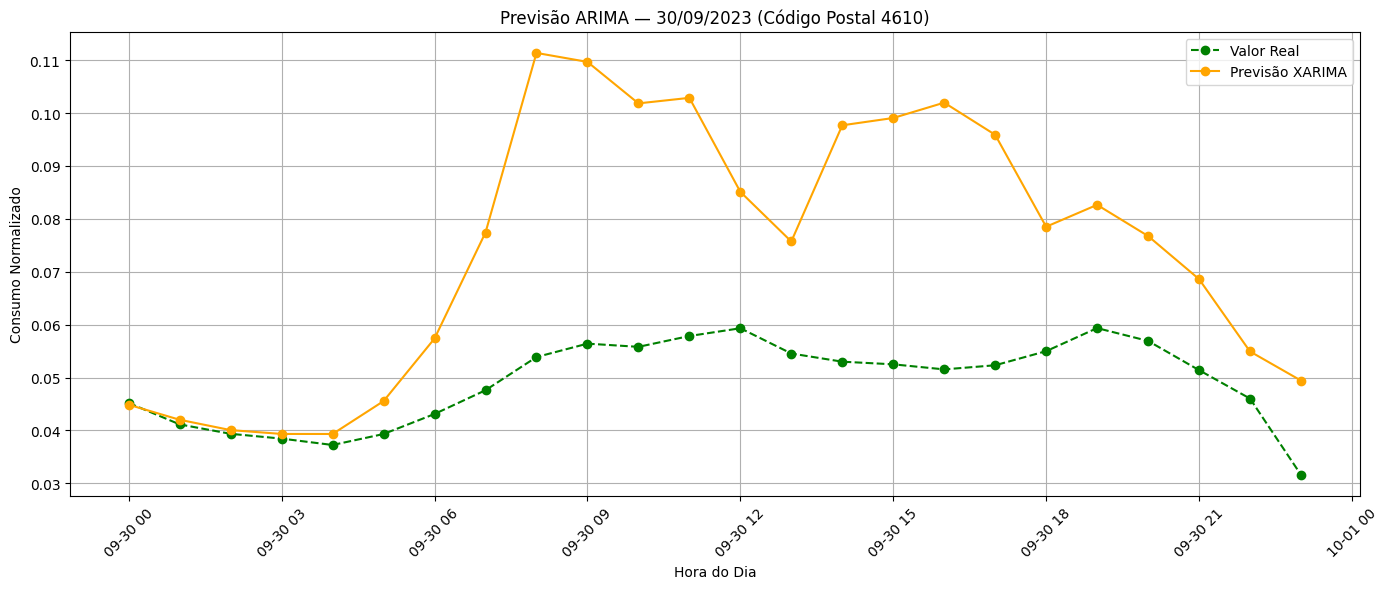

In [43]:
# Compara graficamente as previsões com os valores reais do consumo energético.
timestamps = future_preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão XARIMA", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão ARIMA — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/ARIMA/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊XARIMA com variáveis exógenas

#### 📦 Carregamento e preparação dos dados

In [45]:
# Carrega os dados e filtra para o código postal 4610, ordenando-os por data.
df = pd.read_parquet("./datasets/consumo_eredes_normalizado.parquet")

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Crie um DataFrame de features estáticas único por série:
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
    .copy()
)

# Extrai as features estáticas da série (como densidade populacional).
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Constrói o TimeSeriesDataFrame com colunas de tempo, id e features estáticas.
known_covs = ["Hour", "DayOfTheWeek", "Month", "Season", "IsWeekend", "IsHoliday", "Temperature"]

#### ✂️ Split treino/teste

In [46]:
# Divide os dados em treino e teste, reservando as últimas 24h como hold-out.
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo XARIMA

In [3]:
# (Opcional) Carrega um modelo previamente treinado.
predictor_xarima = TimeSeriesPredictor.load("./predicts/XARIMA/modelo/")

# Treina um modelo ARIMA com CATBoost como regressor de covariáveis.
# known_covariates_names especifica as variáveis exógenas.
# O target_scaler normaliza a série temporal alvo.
predictor_xarima = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/XARIMA/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
        "ARIMAModel": {
            "covariate_regressor": "CAT",
            "target_scaler": "standard",
        }
    },
    time_limit=300,
    presets="medium_quality",
)

predictor_xarima.save() # Guarda o modelo treinado.

#### 🔮Preparação das covariáveis futuras para previsão

In [32]:
# Gera os timestamps das próximas 24 horas.
# Filtra e monta o DataFrame com as covariáveis conhecidas correspondentes.
last_time = train_data.index.get_level_values("timestamp").max()
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

# 2) fatie o df_cp nessas datas:
df_future_covs = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 3) montar o TimeSeriesDataFrame só com essas covariáveis:
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    df_future_covs,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

#### 📈 Previsão e avaliação

In [33]:
# Faz a previsão para o futuro com base nos dados de treino e covariáveis futuras.
preds = predictor_xarima.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Extrai a previsão pontual (mediana) e os valores reais correspondentes.
y_pred = preds["0.5"]
y_true = test_data["EnergyNormalized"].loc[preds.index]
metrics = predictor_xarima.evaluate(test_data)
print("WQL hold‑out com Temperature exógena:", metrics["WQL"])

Model not specified in predict, will default to the model with the best validation score: ARIMA
Model not specified in predict, will default to the model with the best validation score: ARIMA


WQL hold‑out com Temperature exógena: -0.08075431151168086


#### 📊 Cálculo de métricas e intervalos de confiança

In [34]:
# Se quiser um array simples:
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# Erros
abs_errs    = np.abs(y_true - y_pred)
sq_errs     = (y_true - y_pred) ** 2
pct_errs    = np.abs((y_true - y_pred) / y_true) * 100  # em %

# Métricas
MAE  = abs_errs.mean()
MSE  = sq_errs.mean()
RMSE = np.sqrt(MSE)
MAPE = pct_errs.mean()

# 3) Margem de erro de 95% para cada métrica
z = 1.96  # para 95% CI

# Define uma função para calcular margens de erro a 95%, úteis para avaliação estatística da robustez das métricas.
# Intervalos de confiança
def margin_of_error(errs):
    return z * (np.std(errs, ddof=1) / np.sqrt(n))

moe_MAE  = margin_of_error(abs_errs)
moe_MSE  = margin_of_error(sq_errs)
# Para RMSE, pode‐se usar delta‐method: se RMSE = sqrt(MSE),
# então var(RMSE) ≈ var(MSE) / (4*MSE). Para simplicidade aproximamos:
moe_RMSE = moe_MSE / (2 * RMSE)
moe_MAPE = margin_of_error(pct_errs)

#  Exibição das métricas
df_metrics = pd.DataFrame({
    "Métrica":     ["MAE", "MSE", "RMSE", "MAPE (%)"],
    "Valor":       [MAE,  MSE,   RMSE,   MAPE]
})

print(df_metrics)

    Métrica     Valor
0       MAE  0.002807
1       MSE  0.000014
2      RMSE  0.003680
3  MAPE (%)  6.001837


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                                                    |
|----------------------------------------------|---------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00281 | O erro médio absoluto é muito baixo, indicando que as previsões feitas pelo XARIMA estão, em média, apenas 0.0028 unidades afastadas dos valores reais — um excelente resultado. |
| **MSE** (Erro Quadrático Médio)              | 0.00014 | O erro quadrático médio também é bastante reduzido, o que indica que grandes desvios entre previsão e realidade são raros. O modelo tem bom desempenho mesmo nos extremos.       |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00368 | Este valor representa o erro médio esperado com a mesma unidade da variável alvo (consumo normalizado). Um RMSE inferior a 0.004 confirma que o modelo prevê com alta precisão.  |
| **MAPE** (Erro Percentual Absoluto Médio)    | 6.00%   | O erro percentual médio é apenas 6%, o que indica uma excelente capacidade preditiva. Em média, o modelo erra apenas 6% em relação ao valor real, o que é considerado ótimo para séries temporais. |

#### 🖼️ Visualização gráfica

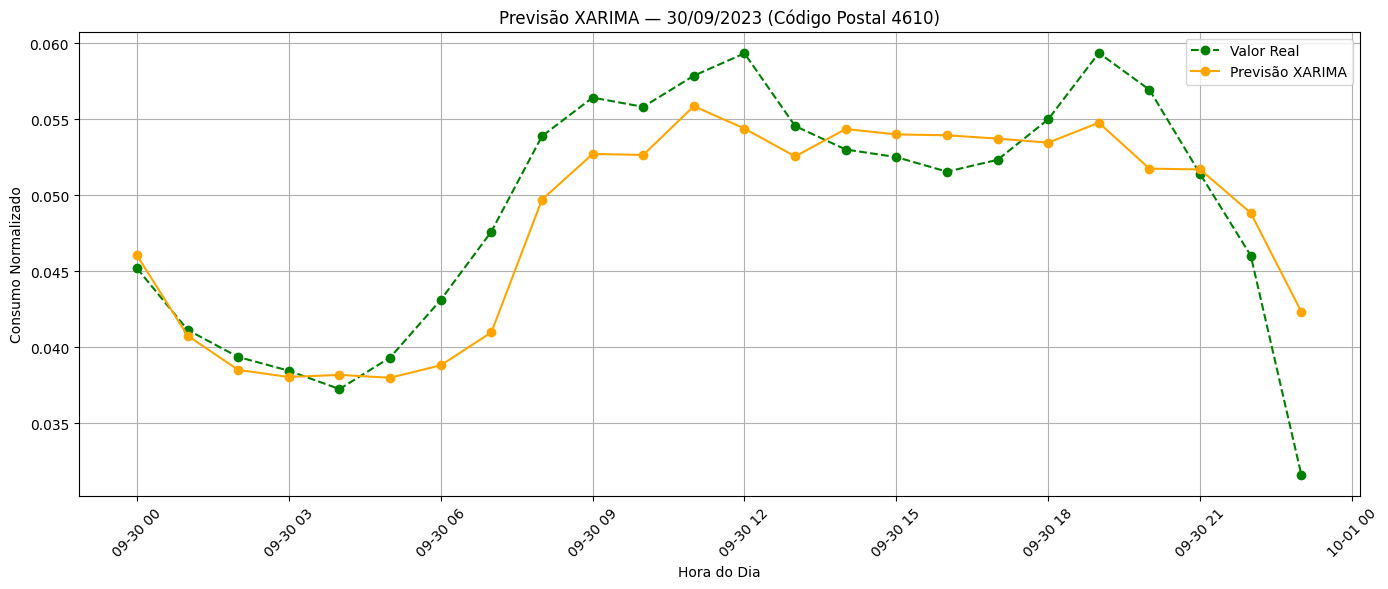

In [35]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão XARIMA", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão XARIMA — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/XARIMA/grafico.png", dpi=300, bbox_inches='tight')
plt.show()